In [ ]:
#importy
import sklearn
import pandas as pd
import numpy as np
import joblib


In [ ]:
# pobranie danych z onedrive
import static_ev as ev
from Funkcje.data_import import load_onedrive_csv

indeksy_df = load_onedrive_csv(ev.indeksy_url)
kombinacje_df = load_onedrive_csv(ev.kombinacje_url)

Pobieranie danych z OneDrive...
Pomyślnie zdekodowano przy użyciu utf-8
Wczytano 108782 wierszy i 266 kolumn
Pobieranie danych z OneDrive...
Pomyślnie zdekodowano przy użyciu windows-1250
Wczytano 386148 wierszy i 13 kolumn


In [3]:
# czyszczenie danych
indeksy_df = indeksy_df[['ID', 'INDEKS', 'NAZWA', 'KOMB_ID']].copy()
kombinacje_df = kombinacje_df[[
    'SEGM_ID', 'KOMB_ID', 'POZYCJA_SEG', 'SLIT_ID', 'SLOW_ID', 
    'KOD', 'OPIS', 'ZALEZNY_OD_ID', 'NAZWA_SLOW', 'ZALEZNY_OD_SLOW_ID'
]].copy()

# zostawiamy tylko te wiersze, które mają wartość w kolumnie KOMB_ID
indeksy_df = indeksy_df.dropna(subset=['KOMB_ID'])

# zostawiamy tylko te indeksy, które zaczynają się od 'M' - Materialy
indeksy_df = indeksy_df[indeksy_df['INDEKS'].str.startswith('M')]

# wyświetlenie wyników czyszczenia
print(f"Liczba wierszy w indeksy_df po czyszczeniu: {len(indeksy_df)}")
print(f"Liczba wierszy w kombinacje_df: {len(kombinacje_df)}")


Liczba wierszy w indeksy_df po czyszczeniu: 67085
Liczba wierszy w kombinacje_df: 386148


In [ ]:
#tokenizacja kolumny nazwa w ramce indeksy_df
from Funkcje.tokenizacja import tokenize_column

indeksy_df_token = tokenize_column(indeksy_df, column_name='NAZWA', model='gpt-3.5-turbo')


Tokenizacja zakończona. Średnia liczba tokenów: 26.47
Maksymalna liczba tokenów: 105
Minimalna liczba tokenów: 2


In [5]:
# przygotowanie ramiki danych do modelu
# dodajemy kolumnę z dwoma pierwszymi segmentami indeksu
indeksy_df_token['INDEKS_SEG_2'] = indeksy_df_token['INDEKS'].str.split('-').str[:2].str.join('-')

# tworzymy ramkę danych do modelu
indeksy_model_1 = indeksy_df_token[['INDEKS', 'NAZWA', 'NAZWA_TOKENS', 'NAZWA_TOKEN_COUNT', 'INDEKS_SEG_2']]  
indeksy_model_1.head()

,INDEKS,NAZWA,NAZWA_TOKENS,NAZWA_TOKEN_COUNT,INDEKS_SEG_2
173,"M-RUR-KOL-76,1-S235-6-46055","KOŁNIERZ Z SZYJKĄ TYP 11 B DN65 76,1X2,9 PN10/...","[56047, 129, 223, 15259, 643, 57, 1901, 70344,...",39,M-RUR
869,"M-RUR-ZSC-139,7-X52-6-65355","RURA 139,7X6,3 X52 PSL1 AT 3.1","[49, 41410, 4194, 10125, 11, 22, 55, 21, 11, 1...",21,M-RUR
870,"M-RUR-ZSC-168,3-X52-6-65353","RURA 168,3X6,3 X52 PSL1 AT 3.1","[49, 41410, 4194, 8953, 11, 18, 55, 21, 11, 18...",21,M-RUR
872,"M-RUR-ZSC-168,3-X52-6-65354","RURA 168,3X8 X52 PSL1 AT 3.1","[49, 41410, 4194, 8953, 11, 18, 55, 23, 4194, ...",20,M-RUR
880,M-SRU-POD-M20-0-0-468,PODKŁADKA ZGRUBNA 22 FEZN OGNIOWO POKRYCIE FLU...,"[2089, 18805, 129, 223, 1846, 27542, 1901, 879...",29,M-SRU


In [ ]:
# trenowanie modelu
from Funkcje.model import train_xgb_model

model, y_test, y_pred, accuracy, report, matrix = train_xgb_model(
    indeksy_model_1, 
    n_estimators=100, 
    n_learning_rate=0.1, 
    n_max_depth=5, 
    n_test_size=0.2, 
    n_random_state=42
)

print(f'Accuracy: {accuracy}')
print('\nClassification Report:')
print(report)
print('\nConfusion Matrix:')
print(matrix)

#wcześniej zwracalismy bledne metryki. Przy klasyfikacji przede wszystkim liczy sie accuracy i classification report, a nie r2 i mean squared error.
    

Accuracy: 0.9451442200193784

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        24
           1       1.00      0.98      0.99        47
           3       1.00      0.33      0.50         3
           4       0.29      0.18      0.22        11
           5       1.00      1.00      1.00       854
           6       0.88      1.00      0.93         7
           7       0.82      0.54      0.65        50
           8       0.87      0.91      0.89       552
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         2
          11       0.63      0.40      0.49        42
          12       0.00      0.00      0.00         1
          13       1.00      0.78      0.88         9
          14       0.83      1.00      0.91         5
          15       0.97      0.95      0.96        37
          16       0.00      0.00      0.00         1
          17       0.85     

/Users/rafalpraca/Documents/Studia/ML_PROJEKT/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rafalpraca/Documents/Studia/ML_PROJEKT/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rafalpraca/Documents/Studia/ML_PROJEKT/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [ ]:
# optymalizacja hiperparametrów z użyciem Optuna

from Funkcje.optuna_optimizer import optimize_xgb_model
results = optimize_xgb_model(
    indeksy_model_1, 
    n_trials=5,
    n_estimators_range=(100, 300),
    learning_rate_range=(0.01, 0.3),
    max_depth_range=(5, 15)
)   

[I 2025-11-18 22:52:00,036] A new study created in memory with name: no-name-6fdd0f1a-bf1d-40e9-a580-4acec58396ca
/Users/rafalpraca/Documents/Studia/ML_PROJEKT/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rafalpraca/Documents/Studia/ML_PROJEKT/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rafalpraca/Documents/Studia/ML_PROJEKT/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined

Best trial:
  Accuracy: 0.9642
  Params: 
    n_estimators: 285
    learning_rate: 0.044622730111236145
    max_depth: 11


In [ ]:
# ponowne trenowanie modelu z najlepszymi hiperparametrami
from Funkcje.model import train_xgb_model

best_params = results['best_params']
model, y_test, y_pred, accuracy, report, matrix = train_xgb_model(
    indeksy_model_1,
    n_estimators=best_params['n_estimators'],
    n_learning_rate=best_params['learning_rate'],
    n_max_depth=best_params['max_depth']
)

/Users/rafalpraca/Documents/Studia/ML_PROJEKT/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rafalpraca/Documents/Studia/ML_PROJEKT/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rafalpraca/Documents/Studia/ML_PROJEKT/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [ ]:
#zapisywanie modelu do pliku do katalogu Modele
joblib.dump(model, 'Modele/xgb_indeksy_model.pkl')


In [ ]:
#ładowanie modelu z pliku
model = joblib.load('Modele/xgb_indeksy_model.pkl')

In [ ]:
#Na podstawie wpisanego testu zamieni go na tokeny, a następnie przewidzi wartość indeksu 2 bloki za pomocą wytrenowanego modelu.

test_text = input("Wprowadź tutaj tekst do tokenizacji i przewidywania indeksu")
test_tokens = tokenize_column(pd.DataFrame({'NAZWA': [test_text]}), column_name='NAZWA', model='gpt-3.5-turbo')['NAZWA_TOKENS'].iloc[0]
max_tokens = indeksy_model_1['NAZWA_TOKENS'].apply(len).max()   
test_X = np.pad(test_tokens, (0, max_tokens - len(test_tokens)), constant_values=0)[:max_tokens].reshape(1, -1)
predicted_index_code = model.predict(test_X)[0]    
predicted_index = indeksy_model_1['INDEKS_SEG_2'].astype('category').cat.categories[predicted_index_code]
print(test_X)
print(f'Predicted INDEKS_SEG_2: {predicted_index}')


Tokenizacja zakończona. Średnia liczba tokenów: 2.00
Maksymalna liczba tokenów: 2
Minimalna liczba tokenów: 2
[[   42 17552     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0]]
Predicted INDEKS_SEG_2: M-TAR


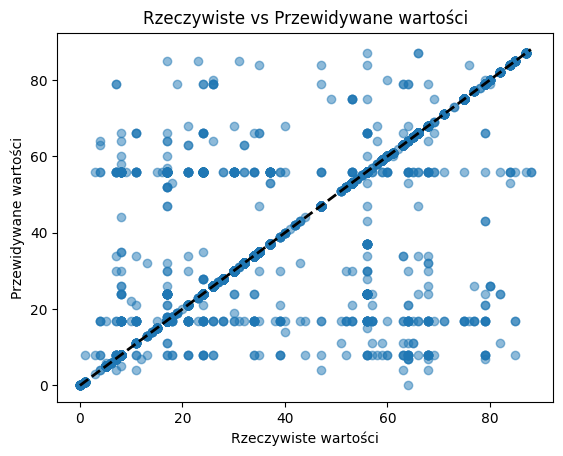

ValueError: x and y must be the same size

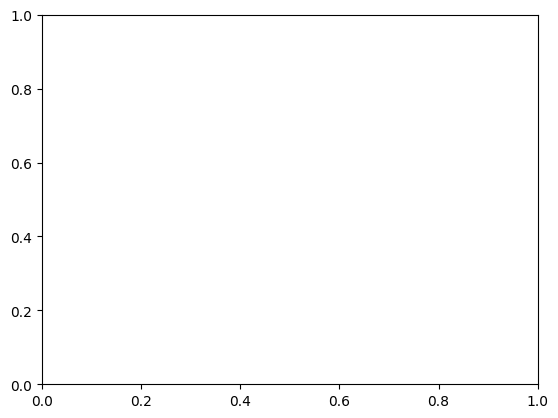

In [12]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Rzeczywiste wartości')
plt.ylabel('Przewidywane wartości')
plt.title('Rzeczywiste vs Przewidywane wartości')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.show()
plt.scatter(y, y_pred, alpha=0.5)

In [ ]:
#

In [ ]:
# Użyj tokenów jako cech zamiast tylko ich liczby
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Przekształć tokeny na macierz cech (np. średnia tokenów, TF-IDF, embeddingi)
max_tokens = indeksy_model_1['NAZWA_tokens'].apply(len).max()
X = np.array([
    np.pad(tokens, (0, max_tokens - len(tokens)), constant_values=0)[:max_tokens]
    for tokens in indeksy_model_1['NAZWA_tokens']
])

# Lub użyj XGBClassifier zamiast XGBRegressor
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)

In [ ]:
from Funkcje.tokenizacja import decode_tokens

# dekodowanie przykładowej wartości tokenów z ramki indeksy_df_token
sample_tokens = indeksy_df_token.iloc[3]['NAZWA_tokens']
decoded_text = decode_tokens(sample_tokens)
print(f"Oryginalna nazwa: {indeksy_df_token.iloc[3]['NAZWA']}")
print(f"Zdekodowany tekst: {decoded_text}")
print(f"Liczba tokenów: {len(sample_tokens)}")

Oryginalna nazwa: RURA 168,3X8 X52 PSL1 AT 3.1
Zdekodowany tekst: RURA 168,3X8 X52 PSL1 AT 3.1
Liczba tokenów: 20
